## Scenario 1, Simple Http Server
### Making the dataset, thats is a load on a pod named "httpdia".
prerequisites:  

minikube start

https://httpd.apache.org/docs/2.4/programs/ab.html

In [1]:
import time
from otumba.utils import manage_pods
from otumba.utils import get_pod_metrics_scenario_1
from otumba.GeneralPod import Pod

In [2]:
ServerPrometheus = "http://192.168.49.2:30000/"
numberpods = 10
request = 500000
concurrency = 10500.0
host = "http://httpdia.default.svc.cluster.local/"
filedataset = "dataset.cvs"
requestpod = "load-generator-jupyter-c"
requestedpod = "httpdia"

In [3]:
lapso="5m"
namespace="default"

In [4]:
respuesta= get_pod_metrics_scenario_1 (server = ServerPrometheus, lapso = lapso, 
                                       namespace = namespace, podname = requestedpod, 
                                        requestpodname = requestpod)

In [5]:
from datetime import datetime
import csv
respuesta["load"] = '1000'
respuesta["date"] = datetime.now()
header = list(respuesta.keys())
print(respuesta)

{'pods': '10.0', 'file_descriptors': '0.0', 'receive_packets': '0.0', 'transmit_packets': '0.0', 'dropped_packets': '0.0', 'cpu_usage_seconds': '0.0004054166', 'cpu_throttled_seconds': '0.0000000000', 'memory_working_bytes': '0.0', 'memory_usage_bytes': '20.0', 'load': '1000', 'date': datetime.datetime(2021, 7, 23, 20, 19, 0, 656578)}


In [6]:
f = open(filedataset, "w", newline='')
writer = csv.DictWriter(f, fieldnames = header)
writer.writeheader()

In [7]:
manage_pods(numberpods, "httpd", requestedpod, "500m", "200m", "default")

Pod Exist, updating replicas


In [8]:
loadpod = Pod(namepod = requestpod, 
              dockerimage = "httpd", namespace = "default", shell = "/bin/sh")

In [9]:
loadpod.create()

In [10]:
carga = "ab -n "+str(request)+" -c "+str(concurrency)+" "+host

In [11]:
loadpod.exec_command(carga)
countstdout=0
while loadpod.resp.is_open():
    resp_stdout=""
    resp_stderr=""
    longitud =0
    respuesta = get_pod_metrics_scenario_1 (server = ServerPrometheus, lapso = lapso, 
                                       namespace = namespace, podname = requestedpod, 
                                        requestpodname = requestpod)
    respuesta["load"] = str(concurrency)
    respuesta["date"] = datetime.now()
    writer.writerow(respuesta)
    if loadpod.resp.peek_stdout():
        resp_stdout= loadpod.resp.read_stdout()
        longitud= len(resp_stdout)
        countstdout= countstdout+1
    if loadpod.resp.peek_stderr():
        resp_stderr=loadpod.resp.read_stderr()
        print("STDERR: %s" % resp_stderr)
        inicioerror = resp_stderr.find("Completed")
        if inicioerror == -1:
            failedrequest=resp_stderr
            break
    if  (longitud >300):
        inicio = resp_stdout.find("Failed requests")
        if (inicio > -1):
            fin = resp_stdout.find("Total transferred")
            failedrequest=resp_stdout[inicio+16:fin-1]
        finalresponse = resp_stdout.split("\n")
    if countstdout==2:
        break
    loadpod.resp.update(timeout=1)
respuesta =  failedrequest.strip()
f.close()

ab -n 500000 -c 10500.0 http://httpdia.default.svc.cluster.local/
STDERR: Completed 50000 requests

STDERR: Completed 100000 requests

STDERR: Completed 150000 requests

STDERR: Completed 200000 requests

STDERR: Completed 250000 requests

STDERR: Completed 300000 requests

STDERR: Completed 350000 requests

STDERR: Completed 400000 requests

STDERR: Completed 450000 requests

STDERR: Completed 500000 requests
Finished 500000 requests



In [12]:
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import networkx as nx

dataframe = pd.read_csv(filedataset)

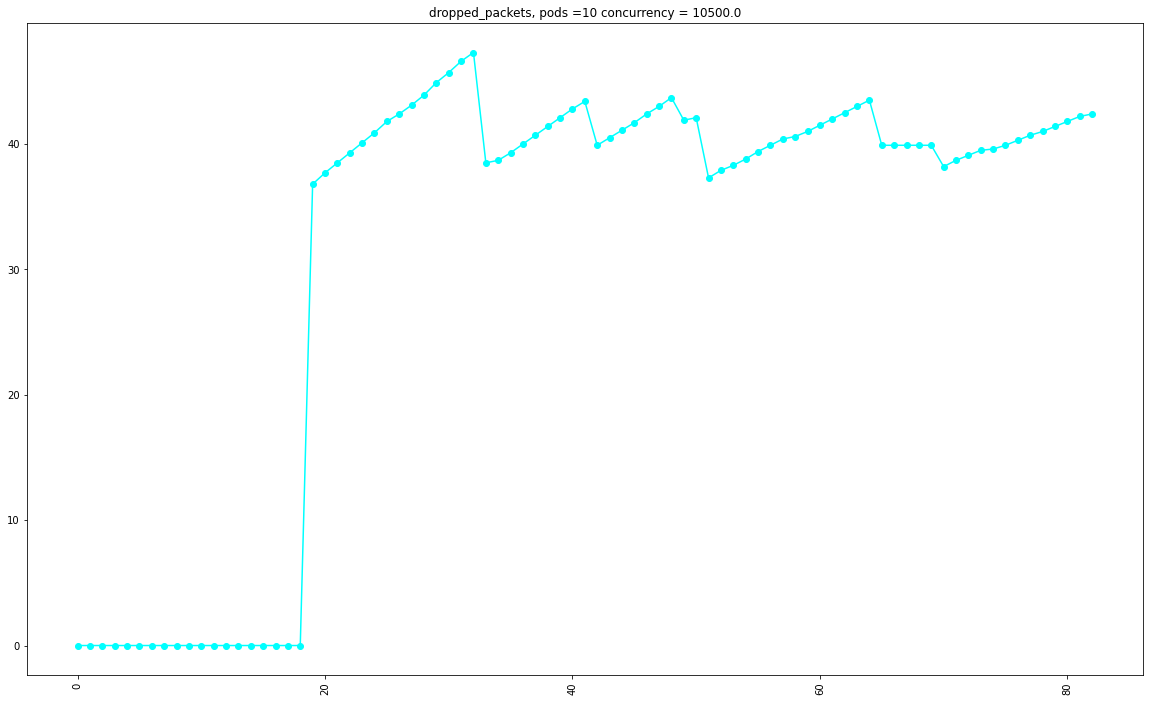

In [13]:
plt.figure(figsize=(20,12))
plt.title("dropped_packets, pods ="+str(numberpods)+" concurrency = "+ str(concurrency) )
plt.xticks(rotation = 90)
plt.plot(dataframe.dropped_packets, c = "cyan", marker = "o")
#plt.plot(dataframe.memory_usage_bytes, c = "green", marker = "o")
plt.show()